In [2]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve


In [3]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'



In [4]:
for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])


In [5]:
processed = {fruit: [] for fruit in fruit_types}

for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])



In [6]:
FRAME_SIZE = 1024 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)


In [7]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration


In [8]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))



In [9]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)



In [10]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal



In [11]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered


In [12]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)
def wiener_filter(signal, noise = 0.9):
    filtered = wiener(signal, noise = noise)
    return filtered
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

def smooth_envelope(signal, sr, cutoff_frequency=50.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)



In [13]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()


In [ ]:

cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER  = band_energy_ratio(spec, split_frequency, sr)
        #BER /= np.max(BER)
        #feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)




**MFCC**

- Media.
Tomando la media al reddedor de 2/5 en la componente 1 con 10 frames, 5 de cada lado, las naranjas se separan una banda de las manzanas. En general la componente 1 separa bien las naranjas, tambien en los 7/10

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200
n_mfcc = 4
componente = 0
# Extracción de características
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//3 - 5) : ((mfccs.shape[1]*2)//3 + 5)], axis = 1)
            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    componente += 1


- RMS. Mejor la media que el RMS

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
componnte = 0
while componente < 30:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 30, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            feat = np.sqrt(np.mean(mfccs**2, axis=1))


            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    input()
    componente += 1


- Máximo. En la componente 3 se separan las manzanas de las peras. En la componente 3 en el 2/5 separa una banda las naranjas de als manzanas

C:\Users\Juan\AppData\Local\Temp\ipykernel_4104\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
C:\Users\Juan\AppData\Local\Temp\ipykernel_4104\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


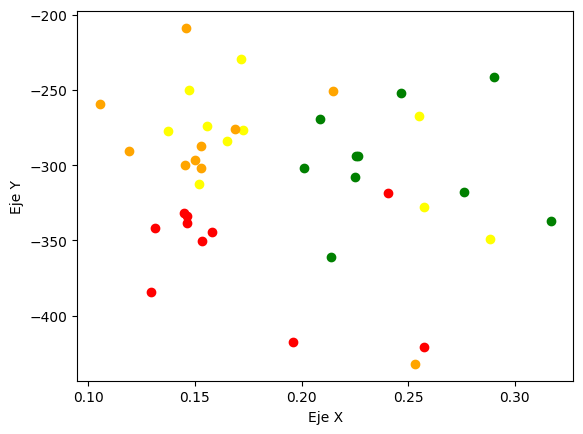

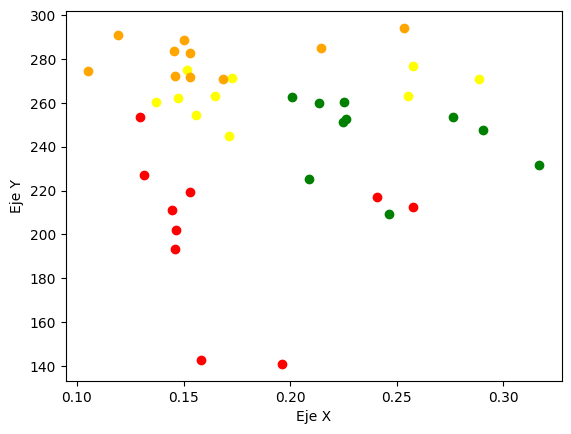

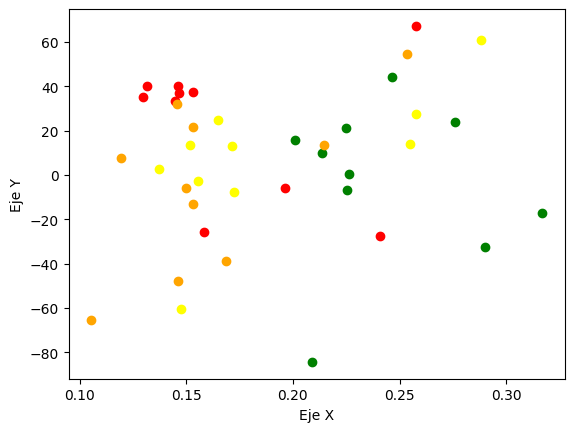

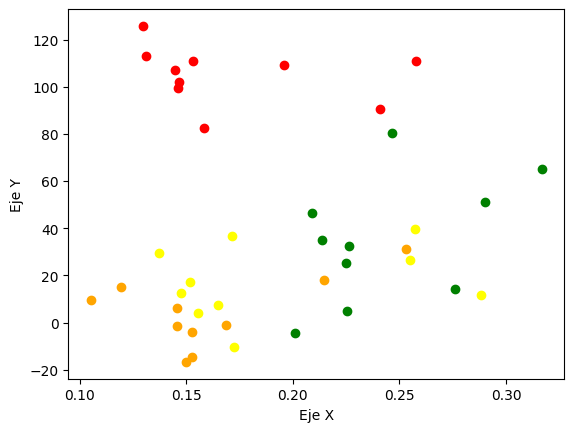

In [14]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200
n_mfcc = 4

# Extracción de características
componente = 0
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    componente += 1


- Mínimo

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
componente = 0
while componente < 30:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 30, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            feat = np.min(mfccs, axis = 1)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    input()
    componente += 1


- Varianza. La componente 1 mas o menos separa las bananas de las naranjas

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200

n_mfcc=4
# Extracción de características
componente = 0
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            feat = np.var(mfccs[:, ((mfccs.shape[1]*1)//2 - 5) : ((mfccs.shape[1]*1)//2 + 5)], axis = 1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    
    componente += 1


- Desviación estándar. Lo mismo que la varianza respecto de la componente 1

C:\Users\Juan\AppData\Local\Temp\ipykernel_6416\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


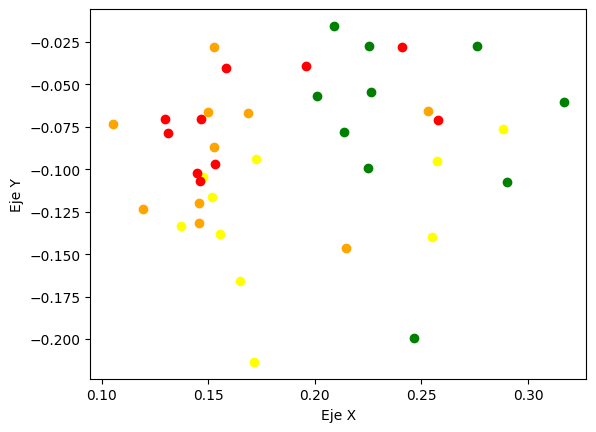

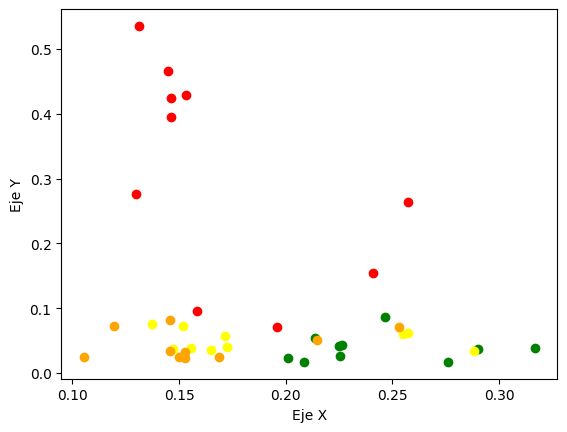

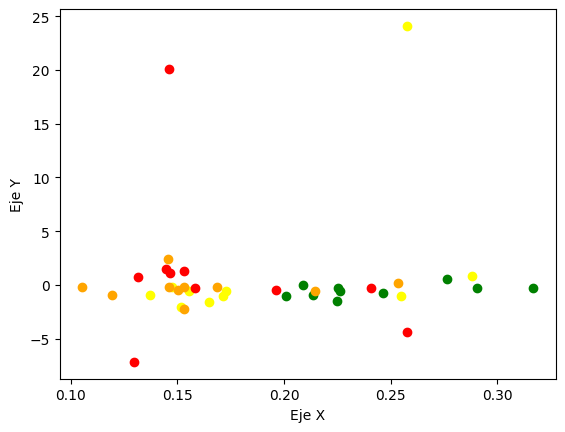

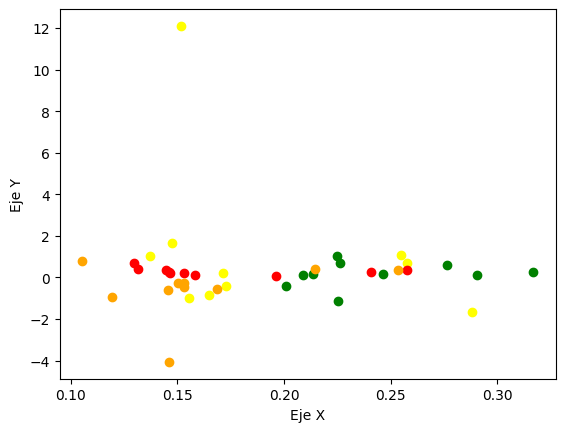

In [49]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
n_mfcc = 4
componente = 0
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            feat = np.std(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)/np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    
    componente += 1


- Con el momento sin la suma

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
componente = 0
while componente < 30:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 30, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            frames = range(mfccs.shape[1])

            t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            feat = np.dot(mfccs, t)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    input()
    componente += 1


- Con el momento con suma. Buena separación de las peras respecto de las demas con la componente 0

C:\Users\Juan\AppData\Local\Temp\ipykernel_6416\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


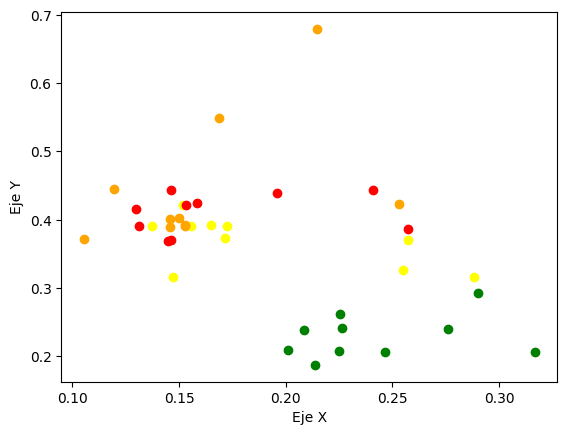

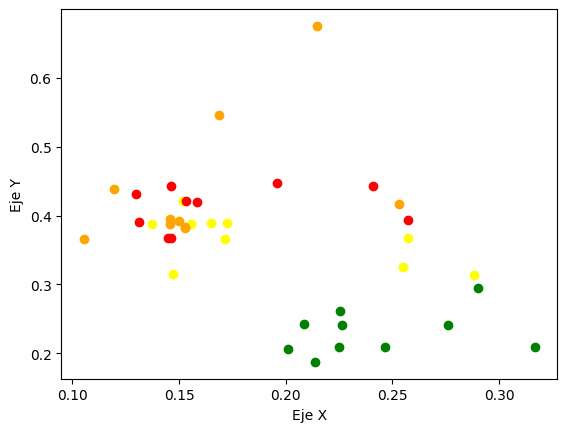

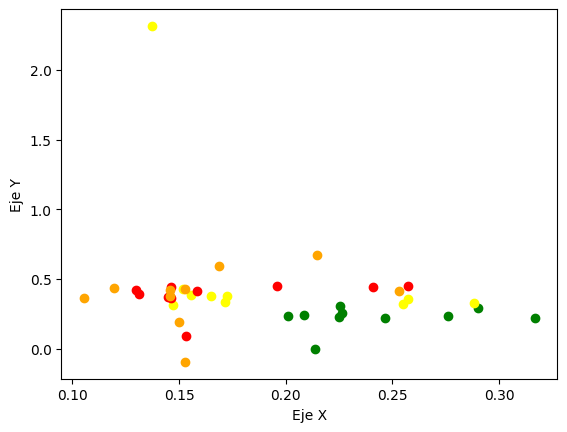

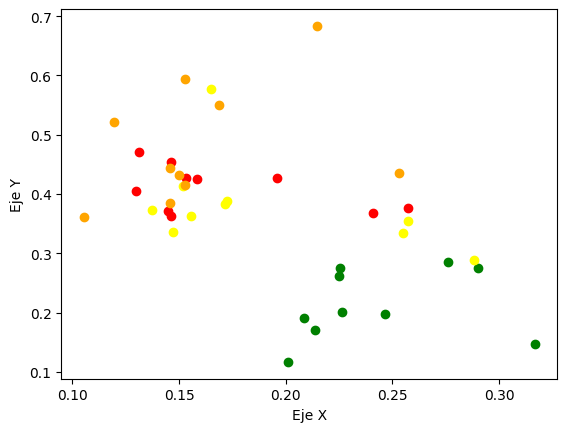

In [53]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
componente = 0
n_mfcc=4
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            frames = range(mfccs.shape[1])

            t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            feat = np.dot(mfccs[:, ((mfccs.shape[1]*3)//5 - 5) : ((mfccs.shape[1]*3)//5 + 5)], t[((len(t)*3)//5 - 5) : ((len(t)*3)//5 + 5)])/np.sum(mfccs[:, ((mfccs.shape[1]*3)//5 - 5) : ((mfccs.shape[1]*3)//5 + 5)], axis = 1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    
    componente += 1


C:\Users\Juan\AppData\Local\Temp\ipykernel_6916\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


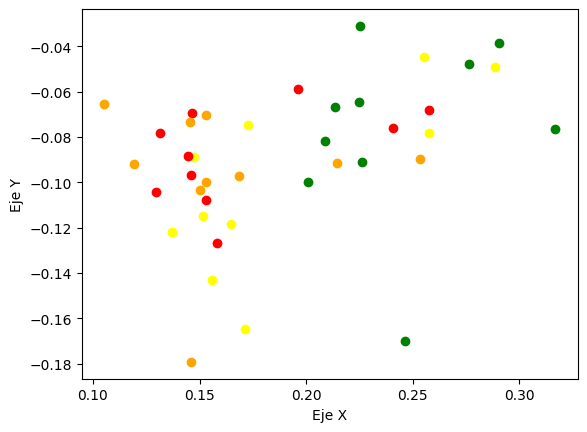

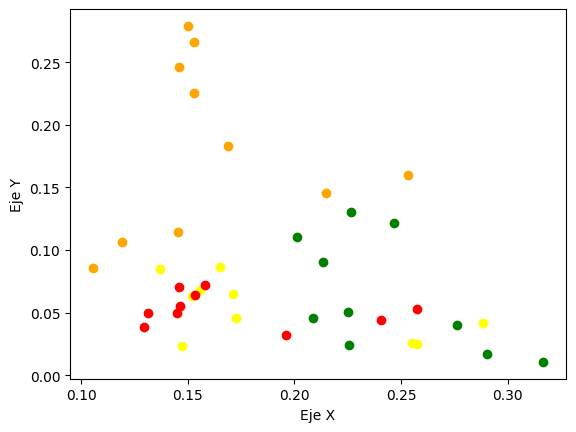

KeyboardInterrupt: Interrupted by user

In [40]:
features = dict.fromkeys(fruit_types)

# Extracción de características
componente = 0
n_mfcc = 13
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            mfccs = mfccs[:, ((mfccs.shape[1]*7) // 10 - 5):((mfccs.shape[1]*3) //10 + 5)] 
            
            frames = range(mfccs.shape[1])

            t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            #feat = np.mean(mfccs, axis=1)
            #feat = np.var(mfccs, axis=1)
            feat = np.std(mfccs, axis=1) / np.mean(mfccs, axis=1)
            #feat = np.max(mfccs, axis=1)
            #feat = np.min(mfccs, axis=1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    input()
    componente += 1

In [45]:
def plot_signal(signal, duration, name):
    time_vector = np.linspace(0, duration, len(signal))
    time_vector/=time_vector[-1]
    plt.figure(figsize=(15, 5))
    
    #plot
    #librosa.display.waveshow(signal)
    
    plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio {name} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

In [43]:
#signal
def plot_audio(audio):
    signal, sr, duration = load_audio(audio)
    plot_signal(signal, duration, os.path.basename(audio))

C:\Users\Juan\AppData\Local\Temp\ipykernel_6916\2951514253.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


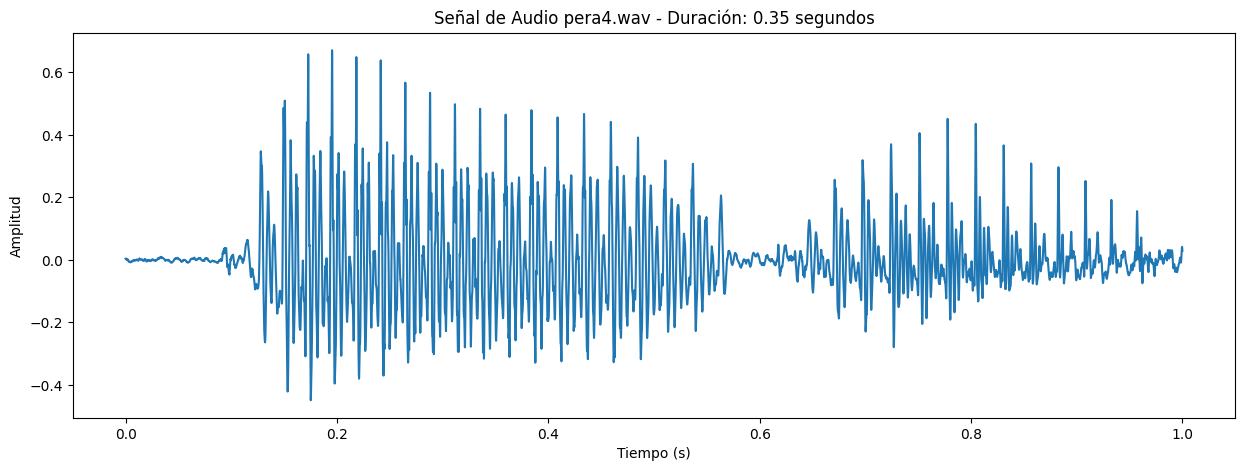

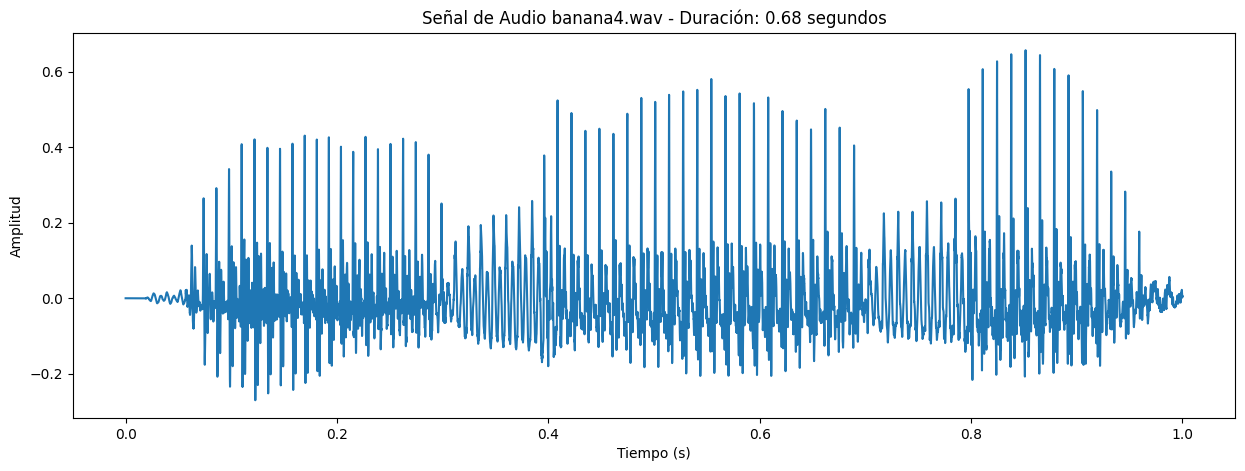

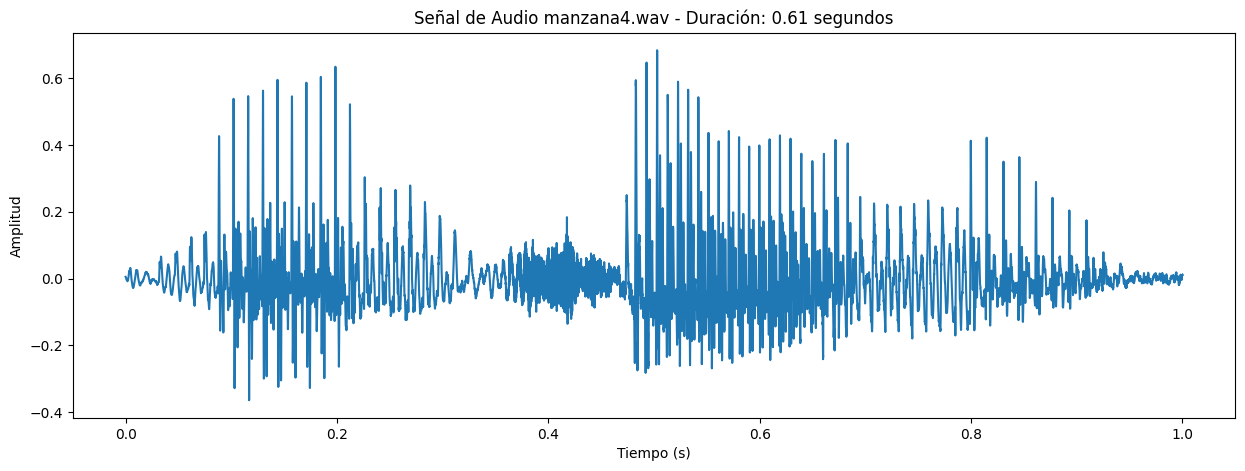

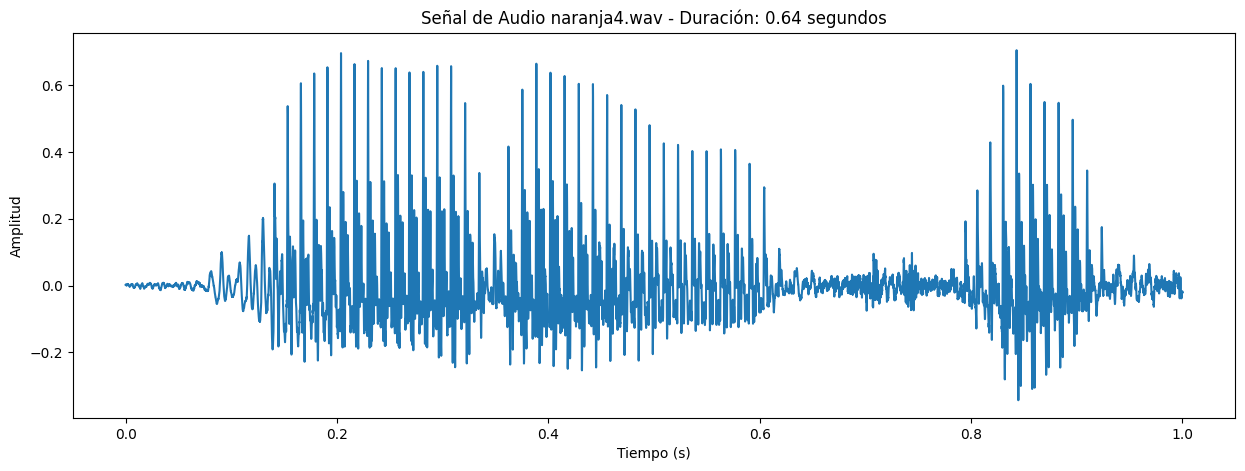

In [46]:
indice = 4
for fruit in processed:
    plot_audio(processed[fruit][indice])